In [1]:
!pip install -q requests

In [2]:
import requests

url = "https://www.dropbox.com/scl/fi/dw8adpyocge43xnczeobj/flights.zip?rlkey=jnzty4kcip6ka2z9ujly1yerv&dl=1"
response = requests.get(url)
with open("flights.zip", "wb") as f:
    f.write(response.content)
!unzip -o flights.zip

Archive:  flights.zip
   creating: flights/
  inflating: flights/Combined_Flights_2022.csv  
  inflating: flights/Airlines.csv    
  inflating: flights/readme.html     


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import shap
%matplotlib inline

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [5]:
df = pd.read_csv('flights/Combined_Flights_2022.csv')
df = df.dropna(subset=['ArrDel15'])  # Drop rows where target is NaN (e.g., cancelled flights)
print(df.head())
print(df.info())
print(df.describe())

   FlightDate                                    Airline Origin Dest  \
0  2022-04-04  Commutair Aka Champlain Enterprises, Inc.    GJT  DEN   
1  2022-04-04  Commutair Aka Champlain Enterprises, Inc.    HRL  IAH   
2  2022-04-04  Commutair Aka Champlain Enterprises, Inc.    DRO  DEN   
3  2022-04-04  Commutair Aka Champlain Enterprises, Inc.    IAH  GPT   
4  2022-04-04  Commutair Aka Champlain Enterprises, Inc.    DRO  DEN   

   Cancelled  Diverted  CRSDepTime  DepTime  DepDelayMinutes  DepDelay  ...  \
0      False     False        1133   1123.0              0.0     -10.0  ...   
1      False     False         732    728.0              0.0      -4.0  ...   
2      False     False        1529   1514.0              0.0     -15.0  ...   
3      False     False        1435   1430.0              0.0      -5.0  ...   
4      False     False        1135   1135.0              0.0       0.0  ...   

   WheelsOff  WheelsOn  TaxiIn  CRSArrTime  ArrDelay  ArrDel15  \
0     1140.0    1220.0    

In [6]:
# Extract hour and minute from CRSDepTime
df['DepHour'] = df['CRSDepTime'] // 100
df['DepMinute'] = df['CRSDepTime'] % 100

# Cyclical encoding for DepHour (24-hour cycle)
df['DepHour_sin'] = np.sin(2 * np.pi * df['DepHour'] / 24)
df['DepHour_cos'] = np.cos(2 * np.pi * df['DepHour'] / 24)

# Cyclical encoding for Month (12-month cycle)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Weekend feature
df['IsWeekend'] = (df['DayOfWeek'] >= 6).astype(int)

# Route feature
df['Route'] = df['Origin'] + '_' + df['Dest']

# Additional numerical features
df['TaxiOut'] = df['TaxiOut'].fillna(df['TaxiOut'].median())  # Impute missing values
df['DepDelayMinutes'] = df['DepDelayMinutes'].fillna(0)  # Impute with 0 for no delay

numerical_cols = ['CRSDepTime', 'CRSElapsedTime', 'Distance', 'DepHour', 'DepMinute',
                  'Flight_Number_Operating_Airline', 'DayofMonth', 'TaxiOut',
                  'DepDelayMinutes', 'DepHour_sin', 'DepHour_cos', 'Month_sin', 'Month_cos']
categorical_cols = ['Airline', 'Origin', 'Dest', 'DayOfWeek', 'IsWeekend', 'Month', 'Route']
target = 'ArrDel15'

In [7]:
# Split data
X = df.drop(target, axis=1)
y = df[target].astype(int)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert categoricals to strings before SMOTE
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Apply SMOTE to numerical features only to avoid string conversion issues
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train[numerical_cols], y_train)
X_train_num = pd.DataFrame(X_train_resampled, columns=numerical_cols)

# Since SMOTE only works on numerical data, reattach categorical columns
# For categorical columns, we'll use the original (unbalanced) categorical data or sample to match SMOTE output
# Here, we replicate categorical data to match the resampled numerical data size
resampled_indices = X_train_resampled.index if hasattr(X_train_resampled, 'index') else np.arange(len(X_train_resampled))
X_train_cat = X_train[categorical_cols].iloc[resampled_indices % len(X_train)].reset_index(drop=True)
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
y_train = y_train_resampled

# Scale numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Get vocabulary for categorical columns
def get_vocabulary(data, col):
    return np.unique(data[col]).tolist()

vocab = {}
for col in categorical_cols:
    vocab[col] = get_vocabulary(X_train, col)

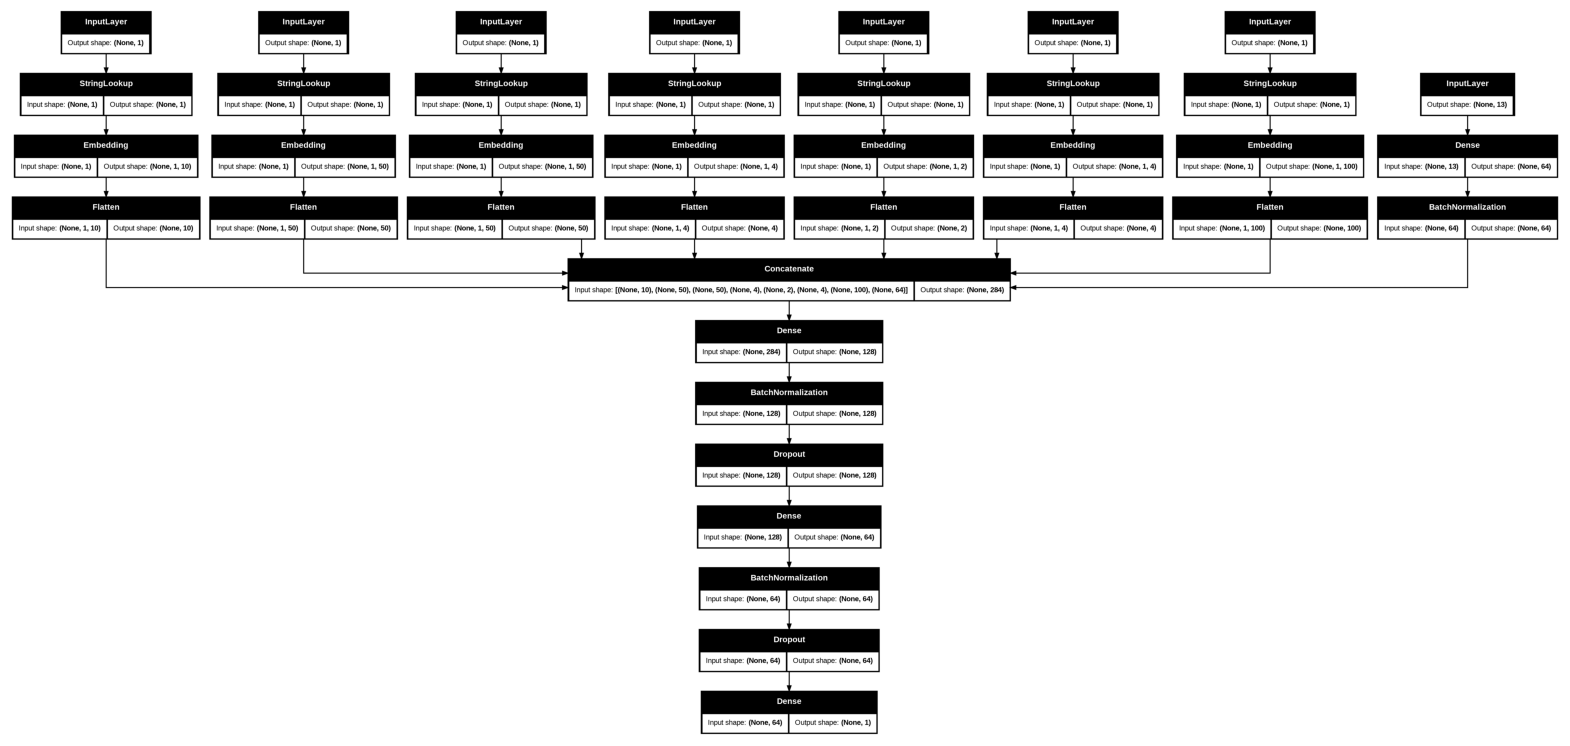

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Airline             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Origin (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dest (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DayOfWeek           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ IsWeekend           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Month (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Route (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup       │ (None, 1)         │          0 │ Airline[0][0]     │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_1     │ (None, 1)         │          0 │ Origin[0][0]      │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_2     │ (None, 1)         │          0 │ Dest[0][0]        │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_3     │ (None, 1)         │          0 │ DayOfWeek[0][0]   │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_4     │ (None, 1)         │          0 │ IsWeekend[0][0]   │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_5     │ (None, 1)         │          0 │ Month[0][0]       │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_6     │ (None, 1)         │          0 │ Route[0][0]       │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical           │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 10)     │        220 │ string_lookup[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │     18,800 │ string_lookup_1[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 50)     │     18,800 │ string_lookup_2[… │
│ (Embedding)         │                   │            │                 

 Total params: 763,711 (2.91 MB)

 Trainable params: 763,199 (2.91 MB)

 Non-trainable params: 512 (2.00 KB)

In [8]:
# Embedding dimensions
embedding_dims = {
    'Airline': 10,
    'Origin': 50,
    'Dest': 50,
    'DayOfWeek': 4,
    'IsWeekend': 2,
    'Month': 4,
    'Route': 100
}

# Inputs
inputs = {}
embeddings = []
for col in categorical_cols:
    vocab_size = len(vocab[col]) + 1  # +1 for unknown
    inp = Input(shape=(1,), name=col, dtype='string')
    inputs[col] = inp
    lookup = tf.keras.layers.StringLookup(vocabulary=vocab[col], mask_token=None)(inp)
    embed = Embedding(input_dim=vocab_size, output_dim=embedding_dims.get(col, 10))(lookup)
    flat = Flatten()(embed)
    embeddings.append(flat)

# Numerical inputs
num_input = Input(shape=(len(numerical_cols),), name='numerical')
inputs['numerical'] = num_input
dense_num = Dense(64, activation='relu')(num_input)
bn_num = BatchNormalization()(dense_num)
embeddings.append(bn_num)

# Concatenate
concat = Concatenate()(embeddings)
dense1 = Dense(128, activation='relu')(concat)
bn1 = BatchNormalization()(dense1)
drop1 = Dropout(0.3)(bn1)
dense2 = Dense(64, activation='relu')(drop1)
bn2 = BatchNormalization()(dense2)
drop2 = Dropout(0.3)(bn2)
output = Dense(1, activation='sigmoid')(drop2)

model = Model(inputs=list(inputs.values()), outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

plot_model(model, show_shapes=True, to_file='model.png')
plt.figure(figsize=(20,20))
img = plt.imread('model.png')
plt.imshow(img)
plt.axis('off')
plt.show()

model.summary()

In [9]:
def df_to_dict(df):
    data_dict = {col: df[col].values for col in categorical_cols}
    data_dict['numerical'] = df[numerical_cols].values
    return data_dict

train_dict = df_to_dict(X_train)
val_dict = df_to_dict(X_val)
test_dict = df_to_dict(X_test)

In [10]:
# Compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = {classes[i]: class_weights[i] for i in range(len(classes))}

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dict, y_train,
    validation_data=(val_dict, y_val),
    epochs=50,
    batch_size=1024,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

Epoch 1/50
3623/3623 ━━━━━━━━━━━━━━━━━━━━ 725s 198ms/step - accuracy: 0.9304 - auc: 0.9748 - loss: 0.1776 - precision: 0.9465 - recall: 0.9123 - val_accuracy: 0.9480 - val_auc: 0.9700 - val_loss: 0.1473 - val_precision: 0.9327 - val_recall: 0.8186
Epoch 2/50
3623/3623 ━━━━━━━━━━━━━━━━━━━━ 717s 198ms/step - accuracy: 0.9631 - auc: 0.9903 - loss: 0.1038 - precision: 0.9789 - recall: 0.9467 - val_accuracy: 0.9488 - val_auc: 0.9711 - val_loss: 0.1447 - val_precision: 0.9460 - val_recall: 0.8096
Epoch 3/50
3623/3623 ━━━━━━━━━━━━━━━━━━━━ 717s 198ms/step - accuracy: 0.9651 - auc: 0.9913 - loss: 0.0980 - precision: 0.9810 - recall: 0.9487 - val_accuracy: 0.9495 - val_auc: 0.9720 - val_loss: 0.1423 - val_precision: 0.9423 - val_recall: 0.8169
Epoch 4/50
3623/3623 ━━━━━━━━━━━━━━━━━━━━ 717s 198ms/step - accuracy: 0.9661 - auc: 0.9917 - loss: 0.0955 - precision: 0.9817 - recall: 0.9498 - val_accuracy: 0.9492 - val_auc: 0.9720 - val_loss: 0.1429 - val_precision: 0.9254 - val_recall: 0.8323
Epoch 5/

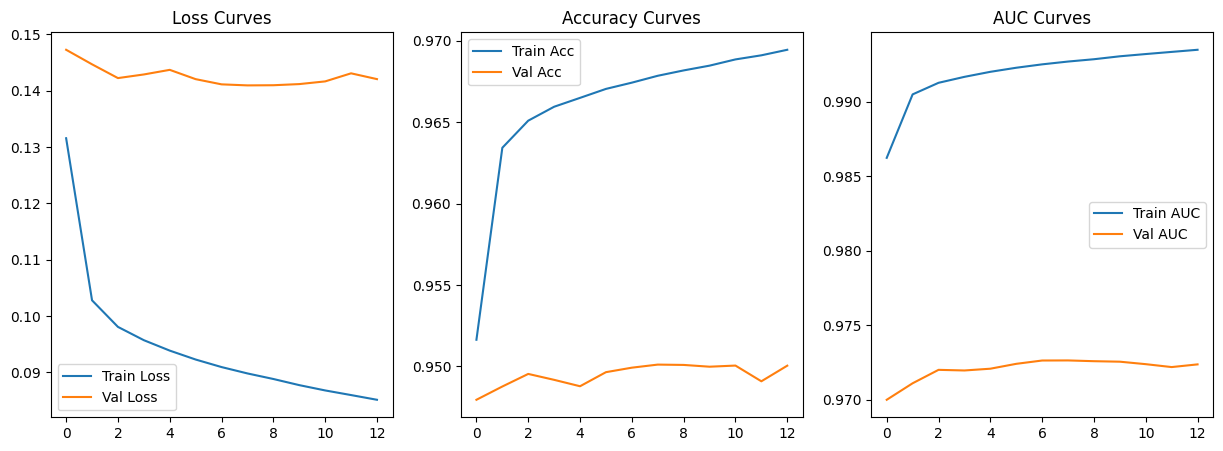

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC Curves')
plt.legend()
plt.show()

24656/24656 ━━━━━━━━━━━━━━━━━━━━ 1053s 43ms/step - accuracy: 0.9496 - auc: 0.9725 - loss: 0.1421 - precision: 0.9339 - recall: 0.8249
Test Accuracy: 0.9494
Test AUC: 0.9720
Test Precision: 0.9342
Test Recall: 0.8244
24656/24656 ━━━━━━━━━━━━━━━━━━━━ 1054s 43ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.97    618191
           1       0.93      0.82      0.88    170793

    accuracy                           0.95    788984
   macro avg       0.94      0.90      0.92    788984
weighted avg       0.95      0.95      0.95    788984



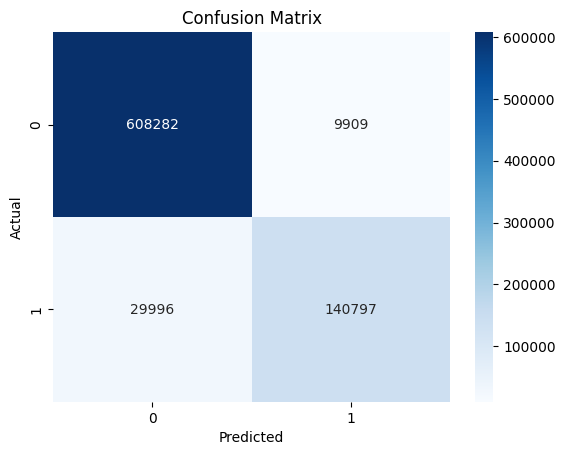

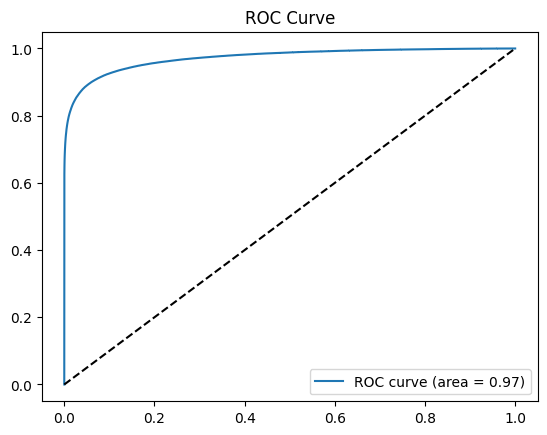

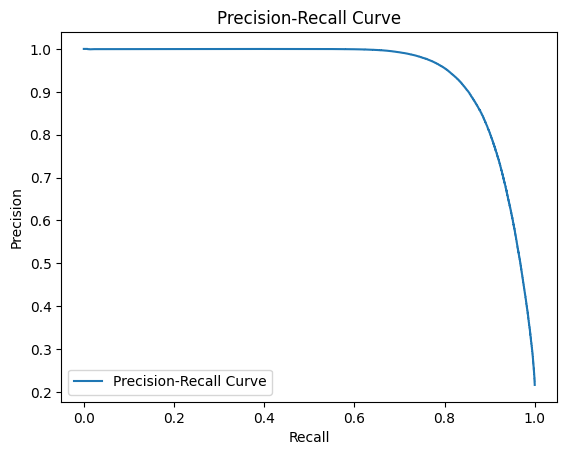

In [12]:
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test_dict, y_test)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test AUC: {test_auc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')

y_pred_prob = model.predict(test_dict)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

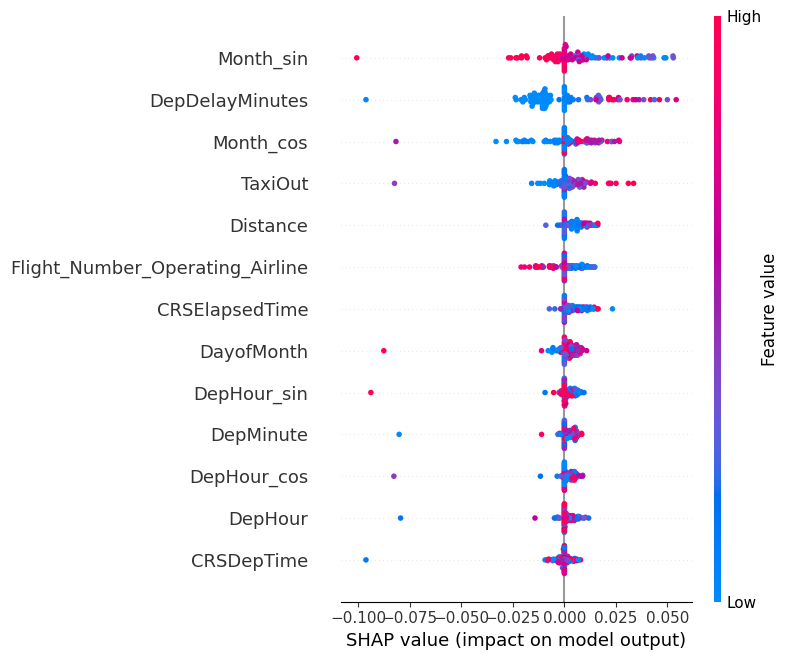

In [22]:
import shap
import numpy as np
import pandas as pd

# Use a smaller subset for SHAP to reduce computation time
sample_indices = X_test.sample(100, random_state=42).index  # Store original indices
X_test_sample = X_test.loc[sample_indices].reset_index(drop=True)  # Reset index for consistency
y_test_sample = y_test.loc[sample_indices].reset_index(drop=True)  # Use original indices for y_test

# Extract numerical features for SHAP
X_test_sample_numerical = X_test_sample[numerical_cols].values

# Define a prediction function that works with numerical features and reattaches categorical features
def predict_fn(X):
    # X is a numpy array of numerical features
    num_samples = X.shape[0]  # Get the number of samples in X
    # Create a DataFrame with numerical features
    temp_df = pd.DataFrame(X, columns=numerical_cols, index=range(num_samples))

    # Reattach categorical features from X_test_sample, ensuring length match
    # Use modulo to cycle through X_test_sample if SHAP provides more samples
    cat_indices = np.arange(num_samples) % len(X_test_sample)
    temp_df[categorical_cols] = X_test_sample[categorical_cols].iloc[cat_indices].values

    # Prepare model input dictionary
    temp_dict = {col: temp_df[col].values for col in categorical_cols}
    temp_dict['numerical'] = temp_df[numerical_cols].values

    # Predict
    return model.predict(temp_dict, verbose=0).flatten()

# Sample background data to reduce computation time
background_data = shap.sample(X_test_sample_numerical, 50)  # Use 50 samples for background

# Create SHAP explainer
explainer = shap.KernelExplainer(predict_fn, background_data)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_sample_numerical)

# Plot SHAP summary for numerical features
shap.summary_plot(shap_values, X_test_sample[numerical_cols], feature_names=numerical_cols)

In [23]:
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import VBox, HBox, Label, Output

# Custom CSS for styling
display(HTML("""
<style>
    .widget-label { font-weight: bold; font-size: 14px; }
    .widget-dropdown, .widget-int-slider, .widget-float-slider { width: 300px; }
    .widget-button { background-color: #4CAF50; color: white; }
    .widget-button:hover { background-color: #45a049; }
    .output-container { border: 1px solid #ddd; padding: 10px; background-color: #f9f9f9; }
</style>
"""))

# Create dropdowns for categorical features
airline_dropdown = widgets.Dropdown(options=vocab['Airline'], value=vocab['Airline'][0], description='Airline:', style={'description_width': 'initial'})
origin_dropdown = widgets.Dropdown(options=vocab['Origin'], value=vocab['Origin'][0], description='Origin:', style={'description_width': 'initial'})
dest_dropdown = widgets.Dropdown(options=vocab['Dest'], value=vocab['Dest'][0], description='Destination:', style={'description_width': 'initial'})
dayofweek_dropdown = widgets.Dropdown(options=vocab['DayOfWeek'], value='4', description='Day of Week:', style={'description_width': 'initial'})
month_dropdown = widgets.Dropdown(options=vocab['Month'], value='3', description='Month:', style={'description_width': 'initial'})
isweekend_dropdown = widgets.Dropdown(options=vocab['IsWeekend'], value='0', description='Is Weekend:', style={'description_width': 'initial'})

# Create sliders for numerical features with dataset-based defaults
crsdeptime_input = widgets.IntSlider(min=0, max=2359, value=int(df['CRSDepTime'].median()), description='CRSDepTime (HHMM):', style={'description_width': 'initial'})
crselapsedtime_input = widgets.FloatSlider(min=df['CRSElapsedTime'].min(), max=df['CRSElapsedTime'].max(), value=df['CRSElapsedTime'].median(), step=1, description='CRSElapsedTime (min):', style={'description_width': 'initial'})
distance_input = widgets.FloatSlider(min=df['Distance'].min(), max=df['Distance'].max(), value=df['Distance'].median(), step=1, description='Distance (miles):', style={'description_width': 'initial'})
dephour_input = widgets.IntSlider(min=0, max=23, value=int(df['CRSDepTime'].median() // 100), description='DepHour:', style={'description_width': 'initial'})
depminute_input = widgets.IntSlider(min=0, max=59, value=int(df['CRSDepTime'].median() % 100), description='DepMinute:', style={'description_width': 'initial'})
flight_number_input = widgets.IntSlider(min=df['Flight_Number_Operating_Airline'].min(), max=df['Flight_Number_Operating_Airline'].max(), value=int(df['Flight_Number_Operating_Airline'].median()), description='Flight Number:', style={'description_width': 'initial'})
dayofmonth_input = widgets.IntSlider(min=1, max=31, value=int(df['DayofMonth'].median()), description='Day of Month:', style={'description_width': 'initial'})
taxiout_input = widgets.FloatSlider(min=df['TaxiOut'].min(), max=df['TaxiOut'].max(), value=df['TaxiOut'].median(), step=1, description='TaxiOut (min):', style={'description_width': 'initial'})
depdelayminutes_input = widgets.FloatSlider(min=0, max=df['DepDelayMinutes'].max(), value=0, step=1, description='DepDelayMinutes:', style={'description_width': 'initial'})

# Route display (read-only)
route_output = widgets.Label(value=f"Route: {origin_dropdown.value}_{dest_dropdown.value}")

# Update Route when Origin or Dest changes
def update_route(change):
    route_output.value = f"Route: {origin_dropdown.value}_{dest_dropdown.value}"

origin_dropdown.observe(update_route, names='value')
dest_dropdown.observe(update_route, names='value')

# Buttons
predict_button = widgets.Button(description="Predict Delay", button_style='success')
reset_button = widgets.Button(description="Reset Inputs", button_style='info')
output = widgets.Output()

# Reset inputs to default values
def on_reset_button_clicked(b):
    airline_dropdown.value = vocab['Airline'][0]
    origin_dropdown.value = vocab['Origin'][0]
    dest_dropdown.value = vocab['Dest'][0]
    dayofweek_dropdown.value = '4'
    month_dropdown.value = '3'
    isweekend_dropdown.value = '0'
    crsdeptime_input.value = int(df['CRSDepTime'].median())
    crselapsedtime_input.value = df['CRSElapsedTime'].median()
    distance_input.value = df['Distance'].median()
    dephour_input.value = int(df['CRSDepTime'].median() // 100)
    depminute_input.value = int(df['CRSDepTime'].median() % 100)
    flight_number_input.value = int(df['Flight_Number_Operating_Airline'].median())
    dayofmonth_input.value = int(df['DayofMonth'].median())
    taxiout_input.value = df['TaxiOut'].median()
    depdelayminutes_input.value = 0
    route_output.value = f"Route: {origin_dropdown.value}_{dest_dropdown.value}"

# Prediction function
def on_predict_button_clicked(b):
    with output:
        output.clear_output()
        print("Predicting...")

        # Validate CRSDepTime and DepHour consistency
        if crsdeptime_input.value // 100 != dephour_input.value:
            print("Error: CRSDepTime hour does not match DepHour. Please adjust.")
            return

        # Collect user inputs
        user_input = {
            'Airline': airline_dropdown.value,
            'Origin': origin_dropdown.value,
            'Dest': dest_dropdown.value,
            'DayOfWeek': dayofweek_dropdown.value,
            'Month': month_dropdown.value,
            'IsWeekend': isweekend_dropdown.value,
            'CRSDepTime': crsdeptime_input.value,
            'CRSElapsedTime': crselapsedtime_input.value,
            'Distance': distance_input.value,
            'DepHour': dephour_input.value,
            'DepMinute': depminute_input.value,
            'Flight_Number_Operating_Airline': flight_number_input.value,
            'DayofMonth': dayofmonth_input.value,
            'TaxiOut': taxiout_input.value,
            'DepDelayMinutes': depdelayminutes_input.value,
            'Route': route_output.value.split(": ")[1]
        }

        # Compute cyclical encodings
        user_input['DepHour_sin'] = np.sin(2 * np.pi * user_input['DepHour'] / 24)
        user_input['DepHour_cos'] = np.cos(2 * np.pi * user_input['DepHour'] / 24)
        user_input['Month_sin'] = np.sin(2 * np.pi * int(user_input['Month']) / 12)
        user_input['Month_cos'] = np.cos(2 * np.pi * int(user_input['Month']) / 12)

        # Create DataFrame for scaling
        user_df = pd.DataFrame([user_input], columns=numerical_cols + categorical_cols)

        # Scale numerical features
        user_df[numerical_cols] = scaler.transform(user_df[numerical_cols])

        # Convert categoricals to strings
        for col in categorical_cols:
            user_df[col] = user_df[col].astype(str)

        # Prepare model input dictionary
        user_dict = {col: user_df[col].values for col in categorical_cols}
        user_dict['numerical'] = user_df[numerical_cols].values

        # Make prediction
        pred_prob = model.predict(user_dict)[0][0]
        pred_label = int(pred_prob > 0.5)

        # Display results
        print("\nPrediction Results:")
        print("Key Features:")
        for feature in ['Airline', 'Origin', 'Dest', 'DepHour', 'Distance', 'Route', 'Month', 'DayOfWeek']:
            print(f"  {feature}: {user_input[feature]}")
        print(f"Predicted Probability of Delay: {pred_prob:.4f}")
        print(f"Predicted Label: {pred_label} (0: No Delay, 1: Delay)")
        print("-" * 40)

        # Visualize prediction with a gauge-like bar
        plt.figure(figsize=(6, 4))
        plt.bar([1], [pred_prob], color='blue' if pred_label == 0 else 'red', alpha=0.7)
        plt.axhline(y=0.5, color='black', linestyle='--', label='Decision Threshold (0.5)')
        plt.xticks([1], ['Flight'])
        plt.ylabel('Predicted Probability of Delay')
        plt.ylim(0, 1)
        plt.title('Flight Delay Prediction')
        plt.legend()
        plt.show()

        print("Prediction completed successfully!")

# Link buttons to functions
predict_button.on_click(on_predict_button_clicked)
reset_button.on_click(on_reset_button_clicked)

# Organize widgets in a clean layout
categorical_box = VBox([Label("Categorical Features"), airline_dropdown, origin_dropdown, dest_dropdown,
                       dayofweek_dropdown, month_dropdown, isweekend_dropdown, route_output])
numerical_box = VBox([Label("Numerical Features"), crsdeptime_input, crselapsedtime_input, distance_input,
                      dephour_input, depminute_input, flight_number_input, dayofmonth_input,
                      taxiout_input, depdelayminutes_input])
button_box = HBox([predict_button, reset_button])
ui = VBox([categorical_box, numerical_box, button_box, output])

# Display UI
display(ui)